In [ ]:
import pandas as pd
import requests
from datetime import datetime, timedelta

# Open-Meteo API URL for historical weather data
open_meteo_url = "https://archive-api.open-meteo.com/v1/archive"

# Define the timeframe
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)
data_chunk = timedelta(days=365)  # 1-year chunks
current_date = start_date
climate_data_list = []

# Function to fetch climate data from Open-Meteo API
def fetch_open_meteo_data(lat, lon, start_date, end_date):
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date.strftime('%Y-%m-%d'),  # Correct format for start_date
        "end_date": end_date.strftime('%Y-%m-%d'),      # Correct format for end_date
        "temperature_2m_max": "true",  # Maximum temperature at 2 meters above ground
        "temperature_2m_min": "true",  # Minimum temperature at 2 meters above ground
        "daily": "temperature_2m_max,temperature_2m_min",  # Get daily max and min temperatures
        "temperature_unit": "celsius",  # Specify the temperature unit (Celsius)
        "timezone": "America/New_York"  # Timezone of your interest, you can change it to your location
    }

    # Sending GET request to Open-Meteo API
    response = requests.get(open_meteo_url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data for {start_date} to {end_date}: {response.status_code}")
        print(response.text)  # Print the error message to debug the response
        return None

# Example: Fetch data for a location in the United States (latitude and longitude)
lat, lon = 37.7749, -122.4194  # San Francisco, CA coordinates

# Loop through the timeframe to fetch data in chunks
while current_date < end_date:
    chunk_start = current_date
    chunk_end = min(current_date + data_chunk, end_date)

    try:
        # Fetch data from Open-Meteo API
        climate_data = fetch_open_meteo_data(lat, lon, chunk_start, chunk_end)

        if climate_data and 'daily' in climate_data:
            # Extract temperature data (Max and Min temperatures)
            daily_data = climate_data['daily']

            # Organize the data into a list
            for date_str, max_temp, min_temp in zip(daily_data['time'], daily_data['temperature_2m_max'], daily_data['temperature_2m_min']):
                climate_data_list.append({
                    'date': datetime.strptime(date_str, '%Y-%m-%d'),
                    'temperature_max': max_temp,
                    'temperature_min': min_temp
                })
    except Exception as e:
        print(f"Error fetching data for {chunk_start} to {chunk_end}: {e}")

    current_date += data_chunk

# Convert list to DataFrame
if climate_data_list:
    climate_df = pd.DataFrame(climate_data_list)
    print("Climate data successfully fetched and combined!")
else:
    print("No climate data fetched.")

# Inspect the DataFrame
print(climate_df.head())

Climate data successfully fetched and combined!
        date  temperature_max  temperature_min
0 2020-01-01             15.4              8.1
1 2020-01-02             14.2              8.6
2 2020-01-03             12.9              6.8
3 2020-01-04             13.3              9.0
4 2020-01-05             13.9              5.9


In [ ]:
import pandas as pd
import requests
from datetime import datetime

# iNaturalist API URL for fetching observations
inaturalist_url = "https://api.inaturalist.org/v1/observations"

# Define the timeframe for wildlife data (same as climate data)
start_date = "2020-01-01"
end_date = "2023-12-31"

# Define parameters for the query
base_params = {
    "taxon_name": "Odocoileus virginianus",  # Example taxon name, for birds. Modify this based on desired species.
    "place_id": "1",  # iNaturalist place ID for the United States. Adjust for different locations.
    "d1": start_date,  # Start date
    "d2": end_date,    # End date
    "per_page": 200,   # Number of records per page (maximum recommended)
}

# Function to fetch wildlife data from iNaturalist using a sliding window
def fetch_inaturalist_data_sliding_window(url, base_params):
    wildlife_data_list = []
    last_id = None  # For sliding window pagination

    while True:
        # Update parameters with sliding window logic
        params = base_params.copy()
        if last_id:
            params['id_above'] = last_id

        # Make the API request
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            results = data.get('results', [])

            if not results:
                break  # Exit the loop if no more results are available

            # Append results to the list
            wildlife_data_list.extend(results)

            # Update last_id to the last record's ID in the current batch
            last_id = results[-1]['id']
        else:
            print(f"Error fetching data: {response.status_code}")
            print(response.text)
            break  # Exit the loop on error

    return wildlife_data_list

# Fetch the wildlife data
wildlife_data = fetch_inaturalist_data_sliding_window(inaturalist_url, base_params)

# Convert to DataFrame
wildlife_df = pd.DataFrame(wildlife_data)

# Clean and convert 'observed_on' (date of observation) column to datetime
if not wildlife_df.empty:
    wildlife_df['observed_on'] = pd.to_datetime(wildlife_df['observed_on']).dt.date  # Remove time part

Error fetching data: 429
<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
  "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
  <head>
    <title>429 Too Many Requests</title>
  </head>
  <body>
    <h1>Too Many Requests</h1>
  </body>
</html>



In [ ]:
# Ensure the climate data 'date' column and wildlife data 'observed_on' are in compatible formats
climate_df['date'] = pd.to_datetime(climate_df['date']).dt.date
wildlife_df['observed_on'] = pd.to_datetime(wildlife_df['observed_on']).dt.date

In [ ]:
# Merge the two datasets on the date
combined_df = pd.merge(
    climate_df,
    wildlife_df,
    left_on='date',
    right_on='observed_on',
    how='inner'
)

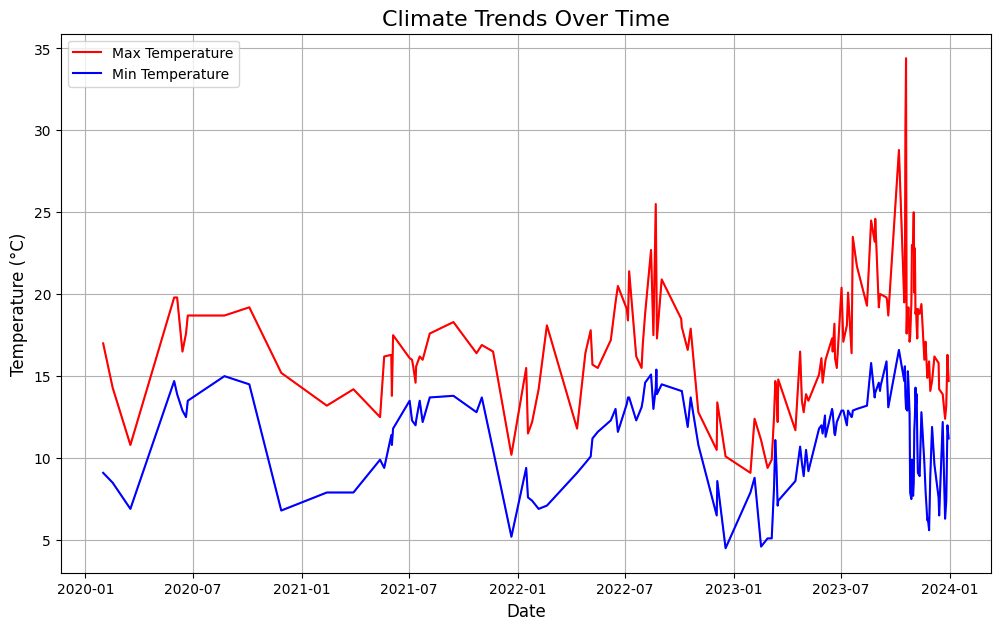

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Ensure the date column is in datetime format
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Climate trends
plt.figure(figsize=(12, 7))
sns.lineplot(x=combined_df['date'], y=combined_df['temperature_max'], label='Max Temperature', color='red')
sns.lineplot(x=combined_df['date'], y=combined_df['temperature_min'], label='Min Temperature', color='blue')
plt.title('Climate Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

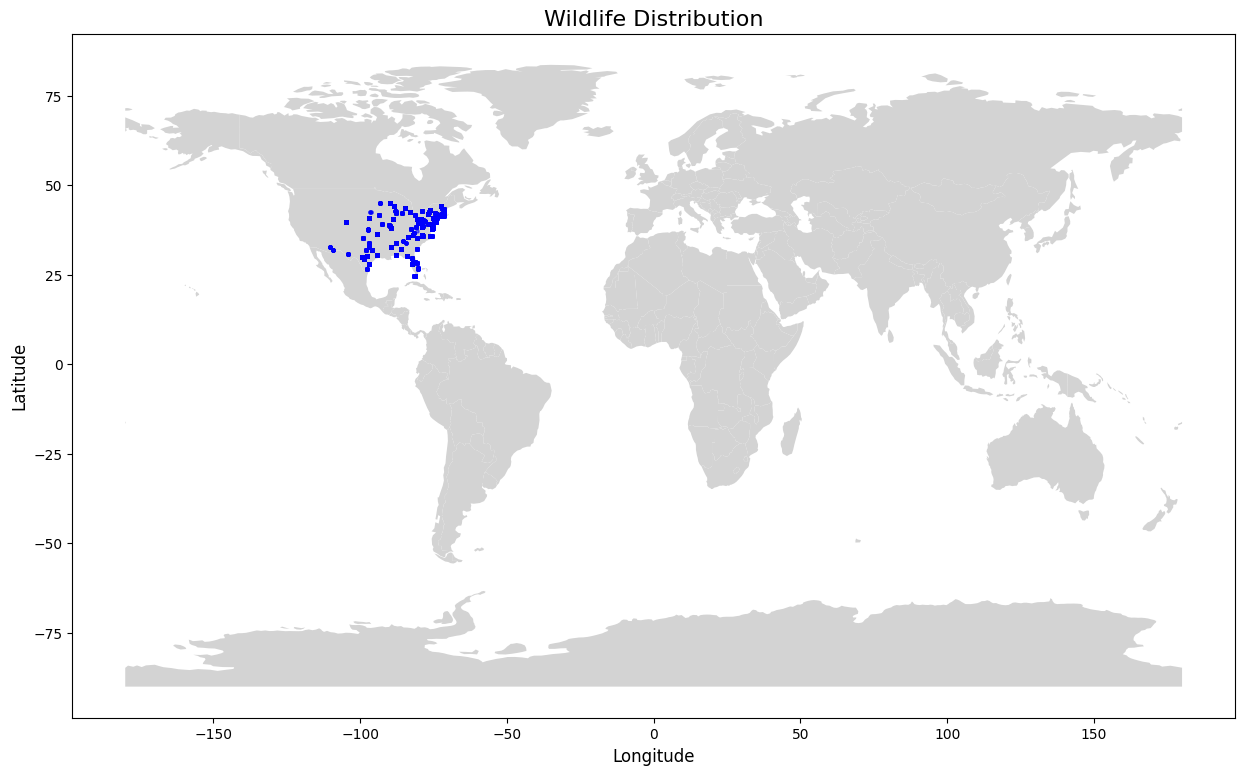

In [ ]:
# Wildlife distribution map
# Extract latitude and longitude from the 'geojson' field, which contains spatial information
wildlife_df['decimalLatitude'] = wildlife_df['geojson'].apply(lambda x: x['coordinates'][1] if x else None)
wildlife_df['decimalLongitude'] = wildlife_df['geojson'].apply(lambda x: x['coordinates'][0] if x else None)
# Drop rows with missing spatial data
wildlife_df = wildlife_df.dropna(subset=['decimalLatitude', 'decimalLongitude'])

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    wildlife_df,
    geometry=gpd.points_from_xy(wildlife_df['decimalLongitude'], wildlife_df['decimalLatitude']),
    crs="EPSG:4326"
)

# Load world map
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")

# Plot wildlife distribution
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.5)
plt.title('Wildlife Distribution', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
# Create additional features
def feature_engineering(df):
    # Add temperature range
    df['temperature_range'] = df['temperature_max'] - df['temperature_min']
    # Add month and day of the year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['day_of_year'] = pd.to_datetime(df['date']).dt.dayofyear
    return df

# Apply feature engineering to both climate and combined datasets
combined_df = feature_engineering(combined_df)

# Ensure no missing values
combined_df.fillna(0, inplace=True)

In [ ]:
# Features: Add engineered features
features = combined_df[['temperature_max', 'temperature_min', 'temperature_range', 'month', 'day_of_year']]
# Target: Binary classification - Predict if the species is observed
target = combined_df['species_guess'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)  # Target: Length of species name (for demo)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
# Initialize Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_pred = gb_model.predict(X_test)

# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        34
           8       1.00      1.00      1.00       110
          10       1.00      1.00      1.00         1
          17       1.00      1.00      1.00      3471
          22       1.00      1.00      1.00        30
          23       1.00      1.00      1.00       160
          26       1.00      1.00      1.00        70
          30       1.00      1.00      1.00        99
          35       1.00      1.00      1.00        12
          36       1.00      1.00      1.00         6

    accuracy                           1.00      3993
   macro avg       1.00      1.00      1.00      3993
weighted avg       1.00      1.00      1.00      3993



In [ ]:
# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate with the best model
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


Fitting 3 folds for each of 54 candidates, totalling 162 fits


ValueError: 
All the 162 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7 8 9], got [ 1  8 10 17 22 23 26 30 35 36]


In [ ]:
# Create a GeoDataFrame for spatial visualization
def create_geodataframe(df, lat_col, lon_col):
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:4326"  # WGS84
    )
    return gdf

# Example: Visualizing observations
wildlife_gdf = create_geodataframe(wildlife_df, 'latitude', 'longitude')

# Visualize on a map
m = folium.Map(location=[wildlife_gdf['geometry'].y.mean(), wildlife_gdf['geometry'].x.mean()], zoom_start=6)

# Add points to the map
for _, row in wildlife_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

m.save("wildlife_observations_map.html")
print("Map saved as wildlife_observations_map.html")

KeyError: 'longitude'

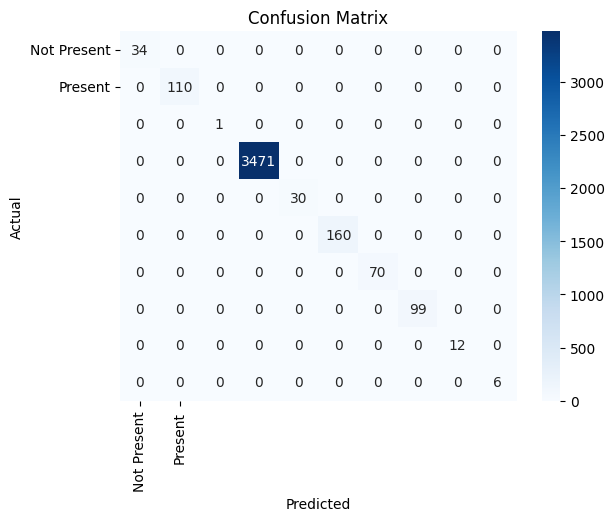

NameError: name 'best_xgb' is not defined

In [ ]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Present', 'Present'], yticklabels=['Not Present', 'Present'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance Plot (XGBoost)
xgb_importances = pd.Series(best_xgb.feature_importances_, index=features.columns)
xgb_importances.sort_values().plot(kind='barh', title='XGBoost Feature Importances')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare dataset for ML
# Example features and target based on combined data columns
features = combined_df[['temperature_max', 'temperature_min']]  # Example climate features
target = combined_df['species_guess'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)  # Target: Length of species name (for demo)
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model Performance
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.0
R2 Score: 1.0


In [ ]:
import dash
from dash import dcc, html
import plotly.express as px

# Initialize Dash App
app = dash.Dash(__name__)

# Temperature Trends Plot
temperature_fig = px.line(
    combined_df,
    x='date',
    y='temperature_max',
    title='Temperature Trends (Max Temperature)',
    labels={'date': 'Date', 'temperature_max': 'Max Temperature'}
)

# Wildlife Distribution Plot
wildlife_fig = px.scatter_mapbox(
    wildlife_df,
    lat='decimalLatitude',
    lon='decimalLongitude',
    hover_name='species_guess',  # Adjusted to match `species_guess` column
    title='Wildlife Distribution',
    mapbox_style="carto-positron",
    zoom=3  # Adjust zoom level as per your data's geographic extent
)

# Layout
app.layout = html.Div([
    html.H1("Climate Change Impact on Wildlife", style={'textAlign': 'center'}),
    dcc.Graph(figure=temperature_fig),
    dcc.Graph(figure=wildlife_fig)
])

# Run the App
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>